# QOSF mentorship program screening task 2

### Author
Mengdi Zhao

### Tools
Jupyter notebook and Qiskit library

### Task 2
The bit-flip code and the sign-flip code are two very simple circuits able to detect and fix the bit-flip and the sign-flip errors, respectively.
1.	Build the circuit to prepare the Bell state. 
2.	Now add, right before the CNOT gate and for each of the two qubits, an arbitrary “error gate”. By error gate we mean that with a certain probability (that you can decide but must be non-zero for all the choices) you have a 1 qubit unitary which can be either the identity, or the X gate (bit-flip error) or the Z gate (sign-flip error).
3.	Encode each of the two qubits with a sign-flip or a bit-flip code, in such a way that all the possible choices for the error gates described in 2), occurring on the logical qubits, can be detected and fixed. Motivate your choice. This is the most non-trivial part of the problem, so do it with a lot of care!
4.	Test your solution by making many measurements over the final state and testing that the results are in line with the expectations.


## Content:
***
1. **Basic tasks:**
 * Buld the circuit to prepare Bell state
 * Add the error gate
 * Design the error correction circuit
 * Simulate mutiple times and visulize the results
 
2. **A more general case**
3. **Conclusion**
***

## Basic tasks

#### Let's first define all the fuctions needed.

In [712]:
#import the required packages
#!pip install -U -r resources/requirements.txt
#from IPython.display import clear_output
#clear_output()

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector, state_fidelity
from qiskit.visualization import plot_state_qsphere, plot_histogram
from qiskit import Aer, execute

import collections
from collections import Counter
import random
import matplotlib.pyplot as plt

In [713]:
# This is the function that will add an error gate of ...
# ... X (with probability p=p_error_X/100), or Z (p=p_error_Z/100) or I (p=(100-p_error_X-p_error_Z)/100)...
# ... to the qubit named qubit_applied in a circuit named given_circuit.

def error_gate(given_circuit, qubit_applied,p_error_X,p_error_Z):  #p_error_x:probability for x gate, p_error_z: for z gate
    p_I=100-p_error_X-p_error_Z      
    for i in qubit_applied:
        n=random.choice([1]*p_error_X + [2]*p_error_Z + [3]*p_I)
        if (n==1):    
            given_circuit.x(i)
            print
        elif (n==2):
            given_circuit.z(i)
        else:
            given_circuit.i(i)

    return given_circuit


# This is the function that will generate the error-correction circuit for a single logical qubit.
# The error gate is included in this circuit already and is applied only on the logical qubit.

def error_correction_simple(given_circuit, qubit_error_applied,qubits_repeat,p_error_x,p_error_z):  #a:probability for x gate, b: for z gate
    given_circuit.cx(qubit_error_applied,qubits_repeat[1])
    given_circuit.h(qubit_error_applied)    
    given_circuit.h(qubits_repeat[1])
    given_circuit.barrier(qubit_error_applied,qubits_repeat)
    given_circuit.cx(qubit_error_applied,qubits_repeat[0])
    
    #given_circuit.barrier()

    ### call the function to generate the error gate
    error_gate(given_circuit, qubit_error_applied,p_error_x,p_error_z)

    #given_circuit.barrier()
    
    given_circuit.cx(qubit_error_applied,qubits_repeat[0])
    given_circuit.cx(qubits_repeat[0],qubit_error_applied)
    given_circuit.barrier(qubit_error_applied,qubits_repeat)
    given_circuit.h(qubit_error_applied)    
    given_circuit.h(qubits_repeat[1])
    given_circuit.cx(qubit_error_applied,qubits_repeat[1])
    given_circuit.cx(qubits_repeat[1],qubit_error_applied)

    return given_circuit


# This is the function that will generate the error-correction circuit for a single logical qubit.
# The error gate is included in this circuit already and is applied on the logical qubit as well as the ancillary qubits.

def error_correction_shor(given_circuit, qubit_error_applied,qubits_repeat,p_error_x,p_error_z):  #a:probability for x gate, b: for z gate
    given_circuit.cx(qubit_error_applied,qubits_repeat[2])
    given_circuit.cx(qubit_error_applied,qubits_repeat[5])
    given_circuit.h(qubit_error_applied)    
    given_circuit.h(qubits_repeat[2])
    given_circuit.h(qubits_repeat[5])
    given_circuit.cx(qubit_error_applied,qubits_repeat[0])
    given_circuit.cx(qubit_error_applied,qubits_repeat[1])
    given_circuit.cx(qubits_repeat[2],qubits_repeat[3])
    given_circuit.cx(qubits_repeat[2],qubits_repeat[4])
    given_circuit.cx(qubits_repeat[5],qubits_repeat[6])
    given_circuit.cx(qubits_repeat[5],qubits_repeat[7])
    
    #given_circuit.barrier()

    ###error gate
    error_gate(given_circuit, qubit_error_applied,p_error_x,p_error_z)
    error_gate(given_circuit, qubits_repeat,p_error_x,p_error_z)

    #given_circuit.barrier()
    
    given_circuit.cx(qubit_error_applied,qubits_repeat[0])
    given_circuit.cx(qubit_error_applied,qubits_repeat[1])
    given_circuit.cx(qubits_repeat[2],qubits_repeat[3])
    given_circuit.cx(qubits_repeat[2],qubits_repeat[4])
    given_circuit.cx(qubits_repeat[5],qubits_repeat[6])
    given_circuit.cx(qubits_repeat[5],qubits_repeat[7])
    
    given_circuit.ccx(qubits_repeat[1],qubits_repeat[0],qubit_error_applied)
    given_circuit.ccx(qubits_repeat[4],qubits_repeat[3],qubits_repeat[2])
    given_circuit.ccx(qubits_repeat[7],qubits_repeat[6],qubits_repeat[5])
    given_circuit.h(qubit_error_applied)    
    given_circuit.h(qubits_repeat[2])
    given_circuit.h(qubits_repeat[5])
    given_circuit.cx(qubit_error_applied,qubits_repeat[2])
    given_circuit.cx(qubit_error_applied,qubits_repeat[5])
    given_circuit.ccx(qubits_repeat[5],qubits_repeat[2],qubit_error_applied)

    return given_circuit


def plot_data(data):
    p = collections.Counter(data)
    probability=[]
    # convert counts to probabilities
    for value in p.values():
        probability.extend([value/sum(p.values())])   
    xlocs, xlabs = plt.xticks()
    xlocs=[i+1 for i in range(0,len(p.keys()))]
    xlabs=[i/2 for i in range(0,len(p.keys()))]  
    plt.bar(p.keys(), probability)
    for i, v in enumerate(probability):
        plt.text(xlocs[i] - 1.15, v+0.01 , str(v))
    plt.title('Distribution of  Measurement Results')
    plt.xlabel('Measurement results')
    plt.ylabel('Probabilities')
    plt.ylim((0,0.6))

### 1. Buld the circuit to prepare Bell state

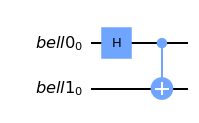

In [723]:
bell_qubit0 = QuantumRegister(1,'bell0')
bell_qubit1 = QuantumRegister(1,'bell1')
BellCircuit = QuantumCircuit(bell_qubit0,bell_qubit1)
BellCircuit.h(0)
BellCircuit.cx(0,1)
BellCircuit.draw('mpl')

### 2. Add the error gates

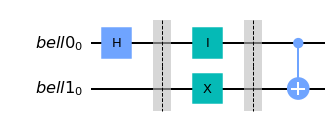

In [724]:
bell_qubit0 = QuantumRegister(1,'bell0')
bell_qubit1 = QuantumRegister(1,'bell1')
BellCircuit_error = QuantumCircuit(bell_qubit0,bell_qubit1)

# Set the probability in percentage
[p_error_x,p_error_z]=[30,30]

BellCircuit_error.h(0)
BellCircuit_error.barrier()
# Randomly (follow the preset probability) add an error gate to each logical qubits
error_gate(BellCircuit_error,[bell_qubit0,bell_qubit1],p_error_x,p_error_z)
BellCircuit_error.barrier()
BellCircuit_error.cx(0,1)

BellCircuit_error.draw('mpl')


### 3. Error correction code
For now, let's assume the error occurs only on the logical qubit (bell_qubit0 and bell_qubit1), not on the ancillary qubits that are used to detect and correct errors. For each logical qubit, I encode it with an error-correction code, which is a combination of the bit-flip code and sign-flip code. Since we assume the error occurs only on the logical qubits, this code is a simplified version of Shor code. Now let's build the error-correction circuit for one arbitrary logical qubit first and I will explain why it works. As is shown below, logical_qubit is the one that matters and that errors will occur on. The qubits_repeat are two ancilary qubits that will help detect and correct error.

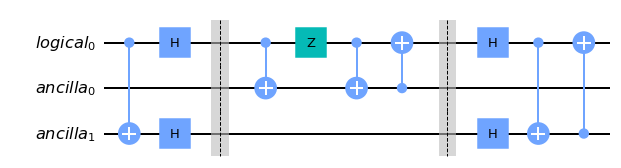

In [725]:
logical_qubit = QuantumRegister(1,'logical')
qubits_repeat = QuantumRegister(2,'ancilla')
# set the error probability
[p_error_x,p_error_z]=[30,30]  

Circuit_ErrorCorrection = QuantumCircuit(logical_qubit,qubits_repeat)
# apply the error correction code together with the error gate
error_correction_simple(Circuit_ErrorCorrection, logical_qubit,qubits_repeat,p_error_x,p_error_z)

Circuit_ErrorCorrection.draw('mpl')

Now let's discuss why this circuit works. Assume we have an arbitrary single logical qubit $|\psi\rangle=\alpha |0\rangle+\beta |1\rangle$ and two ancillary qubits both in state $|0\rangle$.
The initial state of the system is therefore $|\phi_0\rangle=|\psi\rangle|00\rangle$. Right before the error occurs, the systems state has evolved into: 
$$|\phi_1\rangle=\alpha|00+\rangle+\alpha|11+\rangle+\beta|00-\rangle-\beta|11-\rangle$$

Let's consider two senarios: 
1. A bit-flip error occurs on the logical qubit.

This means right after the error gate, the state becomes $|\phi_2\rangle=\alpha|10+\rangle+\alpha|01+\rangle+\beta|10-\rangle-\beta|01-\rangle$. Then at the end of the circuit, we can get the final state: $|\phi_3\rangle=|\psi\rangle|10\rangle$, which means we have corrected the error that occurs on $|\psi\rangle$. And the first ancilary qubit being 1 will indicate a bit-flip error occurred.

2. A sign-lip error occurs on the logical qubit.

This means right after the error gate, the state becomes $|\phi_2^{\prime}\rangle=\alpha|00+\rangle-\alpha|11+\rangle+\beta|00+\rangle-\beta|11-\rangle$. Then at the end of the circuit, we can get the final state: $|\phi_3^{\prime}\rangle=|\psi\rangle|01\rangle$, which means we have corrected the error that occurs on $|\psi\rangle$. And the second ancilary qubit being 1 will indicate a sign-flip error occurred.


**Let's integrate the error-correction circuit with the circuit that generates a Bell state. What is shown below is an example circuit with a certain combination of error gates.**

**Now we will run the simulation mutiple times and measure the logical qubits**

In [732]:
# Set the simulator and number of shots
simulator = Aer.get_backend('qasm_simulator')
# number of simulations
N=1000
# to store the results
data = []

bell_qubit0 = QuantumRegister(1,'bell0')
bell_qubit0_repeat = QuantumRegister(2,'ancilla0')
bell_qubit1 = QuantumRegister(1,'bell1')
bell_qubit1_repeat = QuantumRegister(2,'ancilla1')
cl = ClassicalRegister(2,'c')

BellCircuit_ShorErrorCorrection.draw('mpl')

for x in range(N):    
    BellCircuit_ErrorCorrection = QuantumCircuit(bell_qubit0,bell_qubit0_repeat,bell_qubit1,bell_qubit1_repeat,cl)
    BellCircuit_ErrorCorrection.h(0)
    BellCircuit_ErrorCorrection.barrier()
    error_correction_simple(BellCircuit_ErrorCorrection, bell_qubit0,bell_qubit0_repeat,p_error_x,p_error_z)
    error_correction_simple(BellCircuit_ErrorCorrection, bell_qubit1,bell_qubit1_repeat,p_error_x,p_error_z)
    BellCircuit_ErrorCorrection.barrier()
    BellCircuit_ErrorCorrection.cx(0,3)
    BellCircuit_ErrorCorrection.measure([0,3], [0,1])
    result = execute(BellCircuit_ErrorCorrection, simulator, shots=1, memory=True).result()   
    data.extend(result.get_memory(BellCircuit_ErrorCorrection))


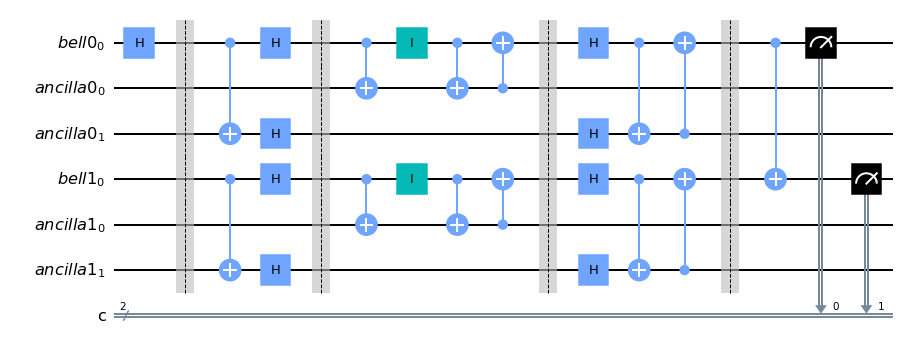

In [733]:
# Show the circuit of the last run
BellCircuit_ErrorCorrection.draw('mpl')

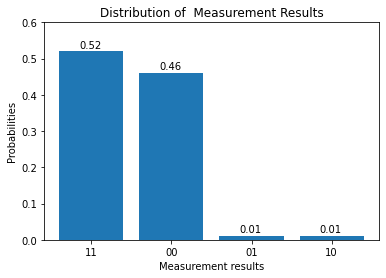

In [716]:
# Visualize the results   
plot_data(data)

As we can see, the results ($00$ and $11$) and their distribution (close to 1:1) are in line with the expectations of measuring a Bell state, even when the probability of error X and Z are 30% respectively. Actually, the succesful correction of the error doens't depend on the probability of error, it can always correct. This is becasue the error only occurs on logical qubits.

A more general and realistic case is that both the logical qubit and the ancillary qubits will experience error, becasue usually they pass the noisy channel together. This brings us to the next section.

## More general case

Now we will assume all qubits, including logical and ancillary qubits, will experience error (with the same probability distribution in types of errors, for simplicity). This is what Shor code is about and we are going to implement Shor code with circuit. 

In [737]:
data = []
simulator = Aer.get_backend('qasm_simulator')
# number of simulations
N=100

bell_qubit0 = QuantumRegister(1,'bell0')
bell_qubit0_repeat = QuantumRegister(8,'ancilla0')
bell_qubit1 = QuantumRegister(1,'bell1')
bell_qubit1_repeat = QuantumRegister(8,'ancilla1')
cl = ClassicalRegister(2,'c')

[p_error_x,p_error_z]=[3,3]

for x in range(N):

    BellCircuit_ShorErrorCorrection = QuantumCircuit(bell_qubit0,bell_qubit0_repeat,bell_qubit1,bell_qubit1_repeat,cl)
    BellCircuit_ShorErrorCorrection.h(0)
    BellCircuit_ShorErrorCorrection.barrier()
    error_correction_shor(BellCircuit_ShorErrorCorrection, bell_qubit0,bell_qubit0_repeat,p_error_x,p_error_z)
    error_correction_shor(BellCircuit_ShorErrorCorrection, bell_qubit1,bell_qubit1_repeat,p_error_x,p_error_z)
    BellCircuit_ShorErrorCorrection.barrier()
    BellCircuit_ShorErrorCorrection.cx(0,9)
    BellCircuit_ShorErrorCorrection.measure([0,9], [0,1])
    result = execute(BellCircuit_ShorErrorCorrection, simulator, shots=1, memory=True).result()   #, shots=10000
    data.extend(result.get_memory(BellCircuit_ShorErrorCorrection))


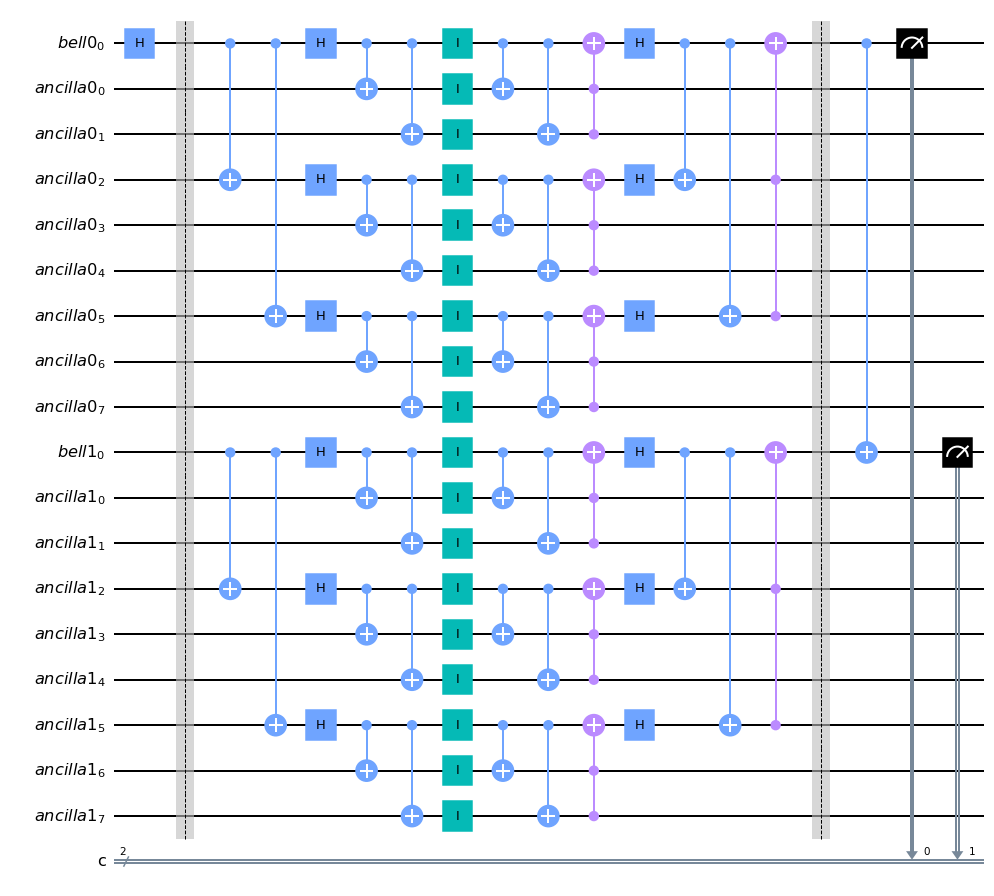

In [738]:
# Show the circuit of the last run
BellCircuit_ShorErrorCorrection.draw('mpl')

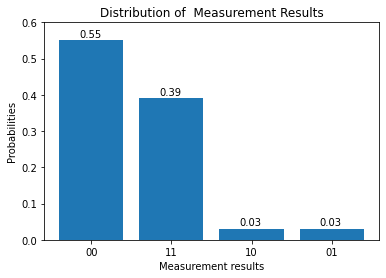

In [739]:
# Visualize the results   
plot_data(data)

As we can see, except for $00$ and $11$ (which still dominant in the results), we also measured $01$ and $10$. This is because Shor code is based on the assumption that the probablity of error needs to be very low so that at most one qubit will experience the error. However, it is still possible that more than one error will occur. When that happens, not all errors can be fixed, so we will get the result of $01$ and $10$ which indicates that we fail to generate Bell state. The lower the probability of the error, the higher chance that we will successfully correct the error and generate Bell state.

# Reference
https://en.wikipedia.org/wiki/Quantum_error_correction